# Introduction :

This dataset has been found on Kaggle. However it is originally from the National Institute of Diabetes and Digestive and Kidney Diseases.
This dataset is used to predict whether or not a patient has diabetes, based on given features/diagnostic measurements.

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

- Input :

    - Pregnancies: Number of times pregnant

    - Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

    - BloodPressure: Diastolic blood pressure (mm Hg)

    - SkinThickness: Triceps skin fold thickness (mm)

    - Insulin: 2-Hour serum insulin (mu U/ml)

    - BMI: Body mass index (weight in kg/(height in m)^2)

    - DiabetesPedigreeFunction: Diabetes pedigree function

    - Age: Age (years)

- Output :

    - Outcome: Class variable (0 or 1)


In [96]:
#import the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearnex import patch_sklearn

#import machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import os

#import parallel processing libraries
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import multiprocessing as mp

#import saving model libraries
import joblib


In [97]:
#Make the machine learning runnin quicker
patch_sklearn()

# Fix the number of CPU used :
nCPU = os.cpu_count()
pool = ThreadPool(processes=nCPU)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [98]:
#import the dataset
path = os.path.abspath("../Data/diabetes.csv")

# import the data into a pandas dataframe :
# Import DataSet with parallelization on the different Cpus
def import_df(file_name):
    df = pd.read_csv(file_name)
    return df
df = pool.apply_async(import_df, (path, )).get()

# Exploratory data analysis

In [6]:
#show the dataset
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [7]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [9]:
#count the null values in the dataset
df.isnull().sum().sum()

0

In [10]:
#Look at deeper in the dataset
pd.DataFrame(df.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Good  There is no missing value and all features type are number. 

However, we can see that some variabe has 0 as value which can be very strange for the glucose, bloodpressure, skinthickness, insulin and BMI. Let's delve deeper into these variables.

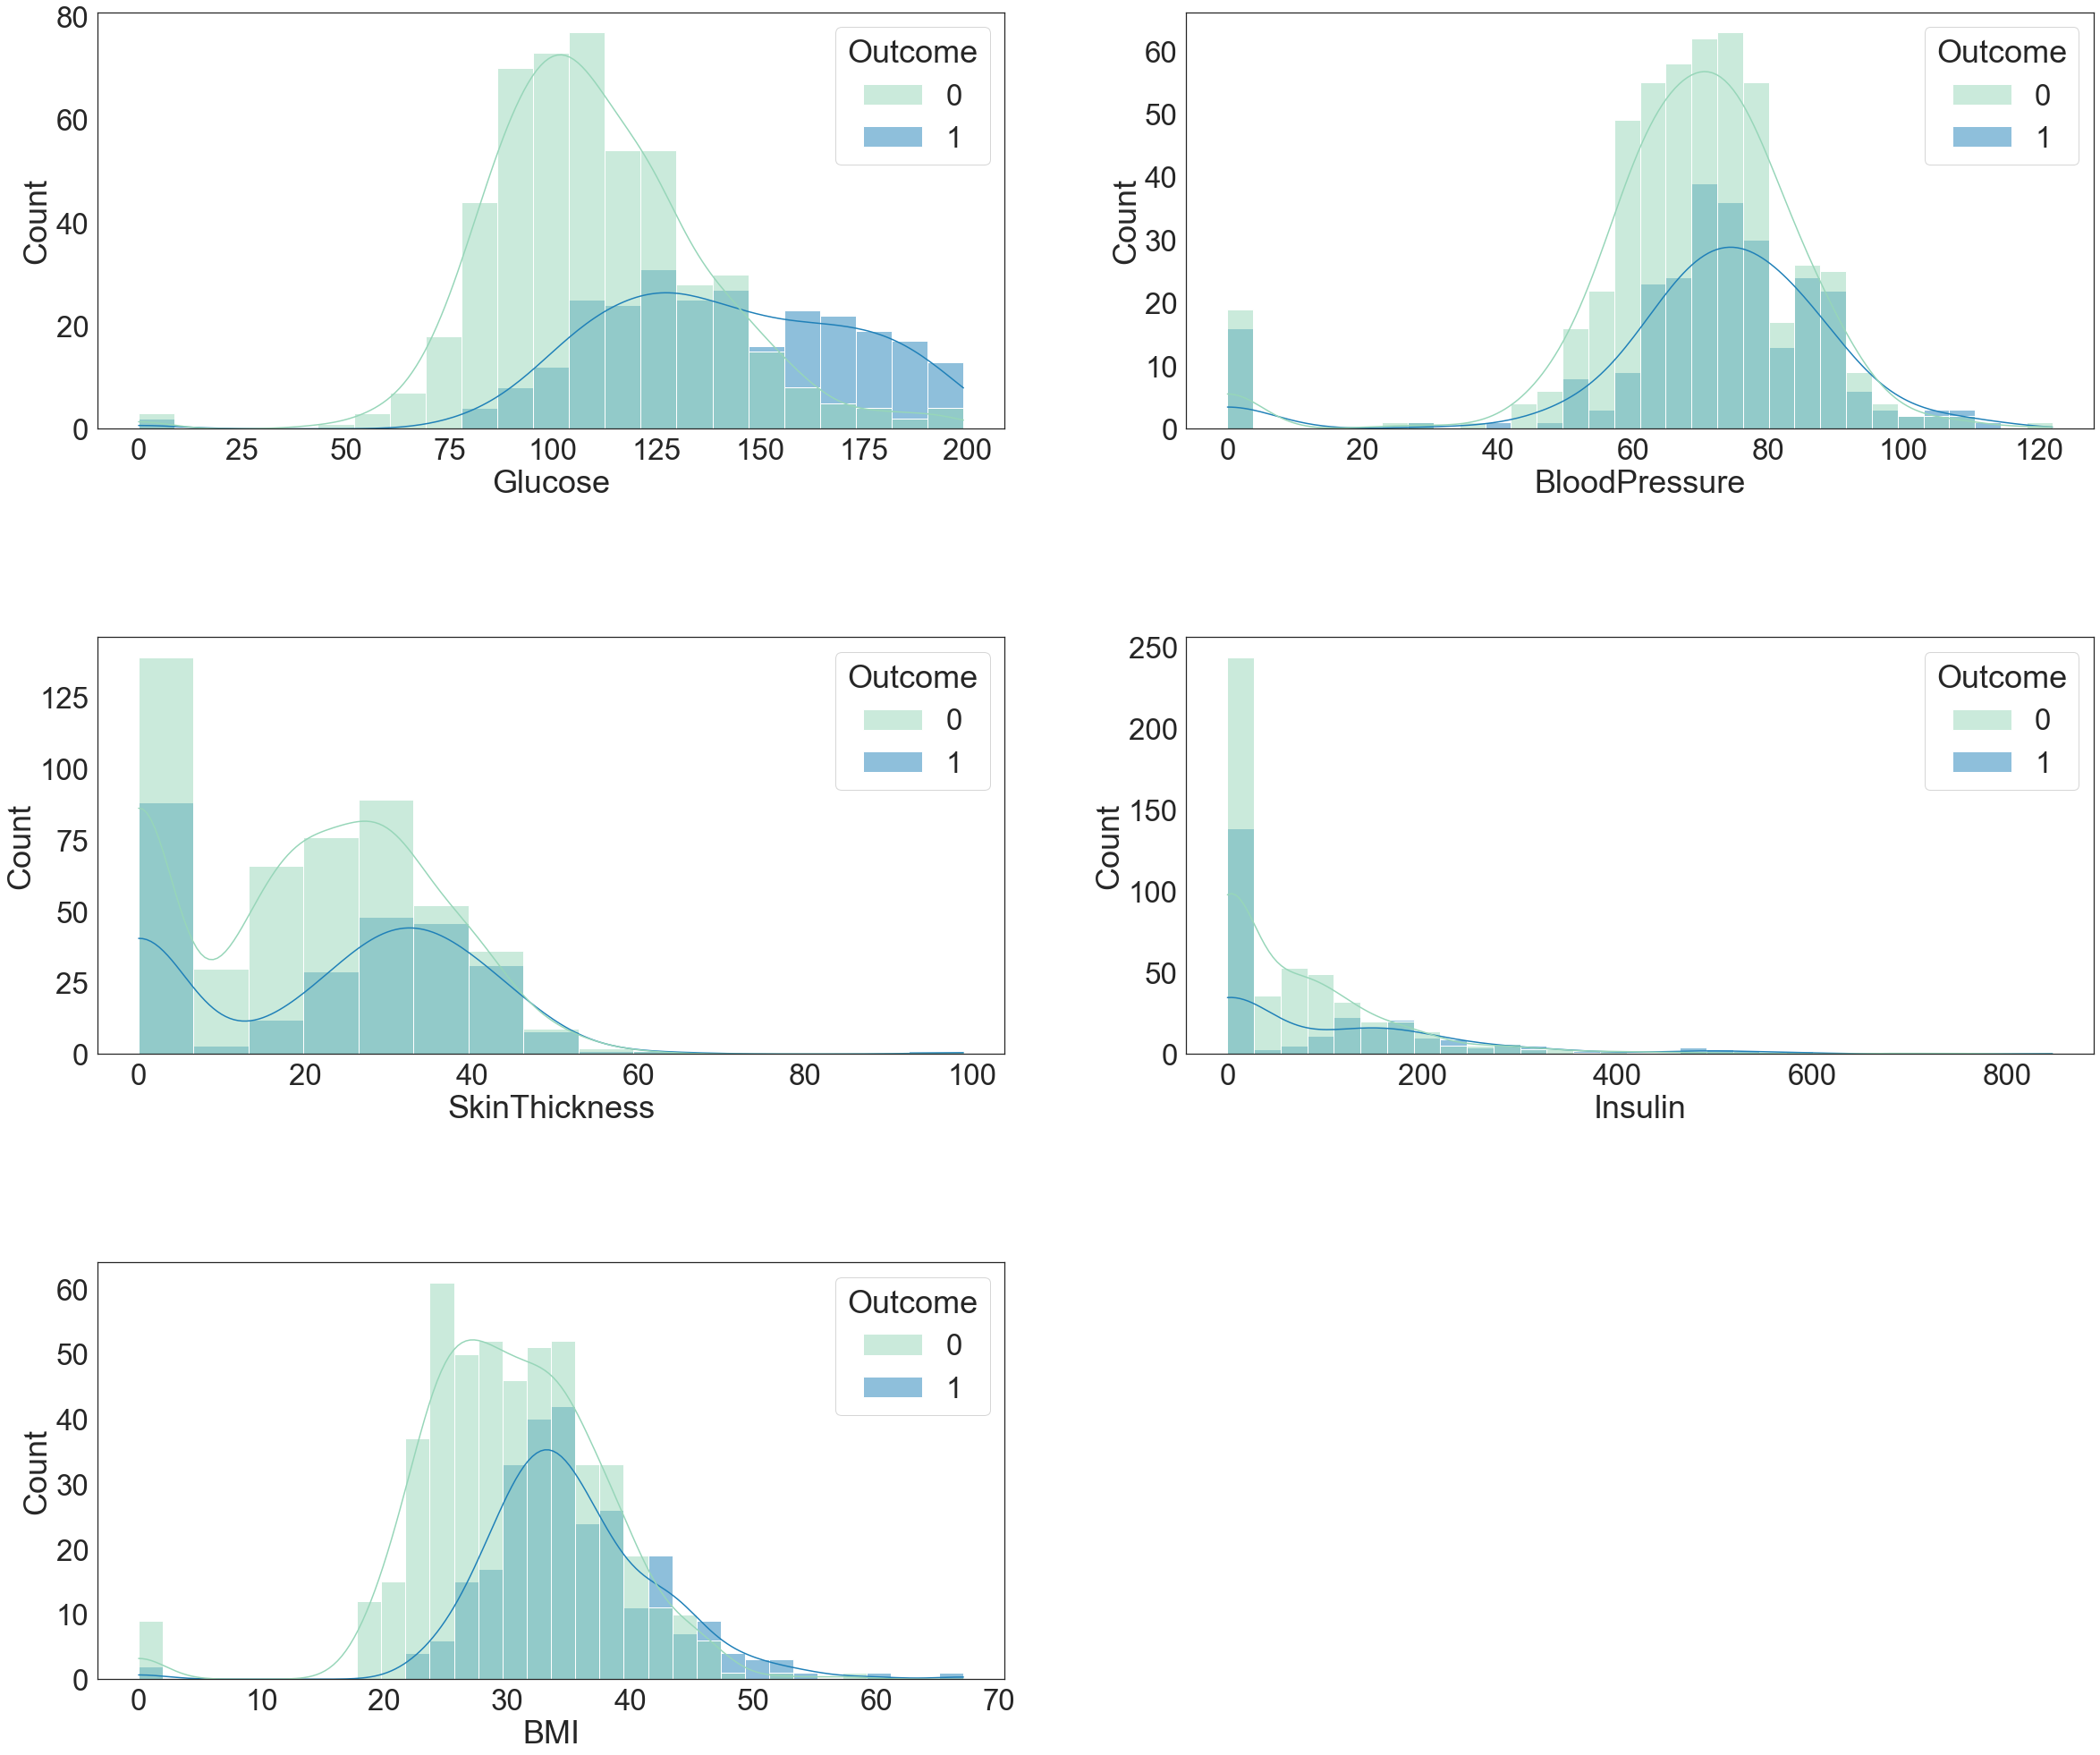

In [99]:
feature_names = [cname for cname in df.loc[:,'Glucose':'BMI'].columns]

plt.rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Looking at the pictures above, it would be good to change the zero value of each feature to another value. First, let's calculate the proportion of zero values in each feature.

In [100]:
zero_features = ['Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = df['Glucose'].count()

for feature in zero_features:
    zero_count = df[df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


As shown above, the ratio of the value of zero in the SkinThickness and Insulin features seems to be high. Let's change the corresponding values to the mean value of each feature.

In [101]:
diabetes_mean = df[zero_features].mean()
df[zero_features] = df[zero_features].replace(0, diabetes_mean)

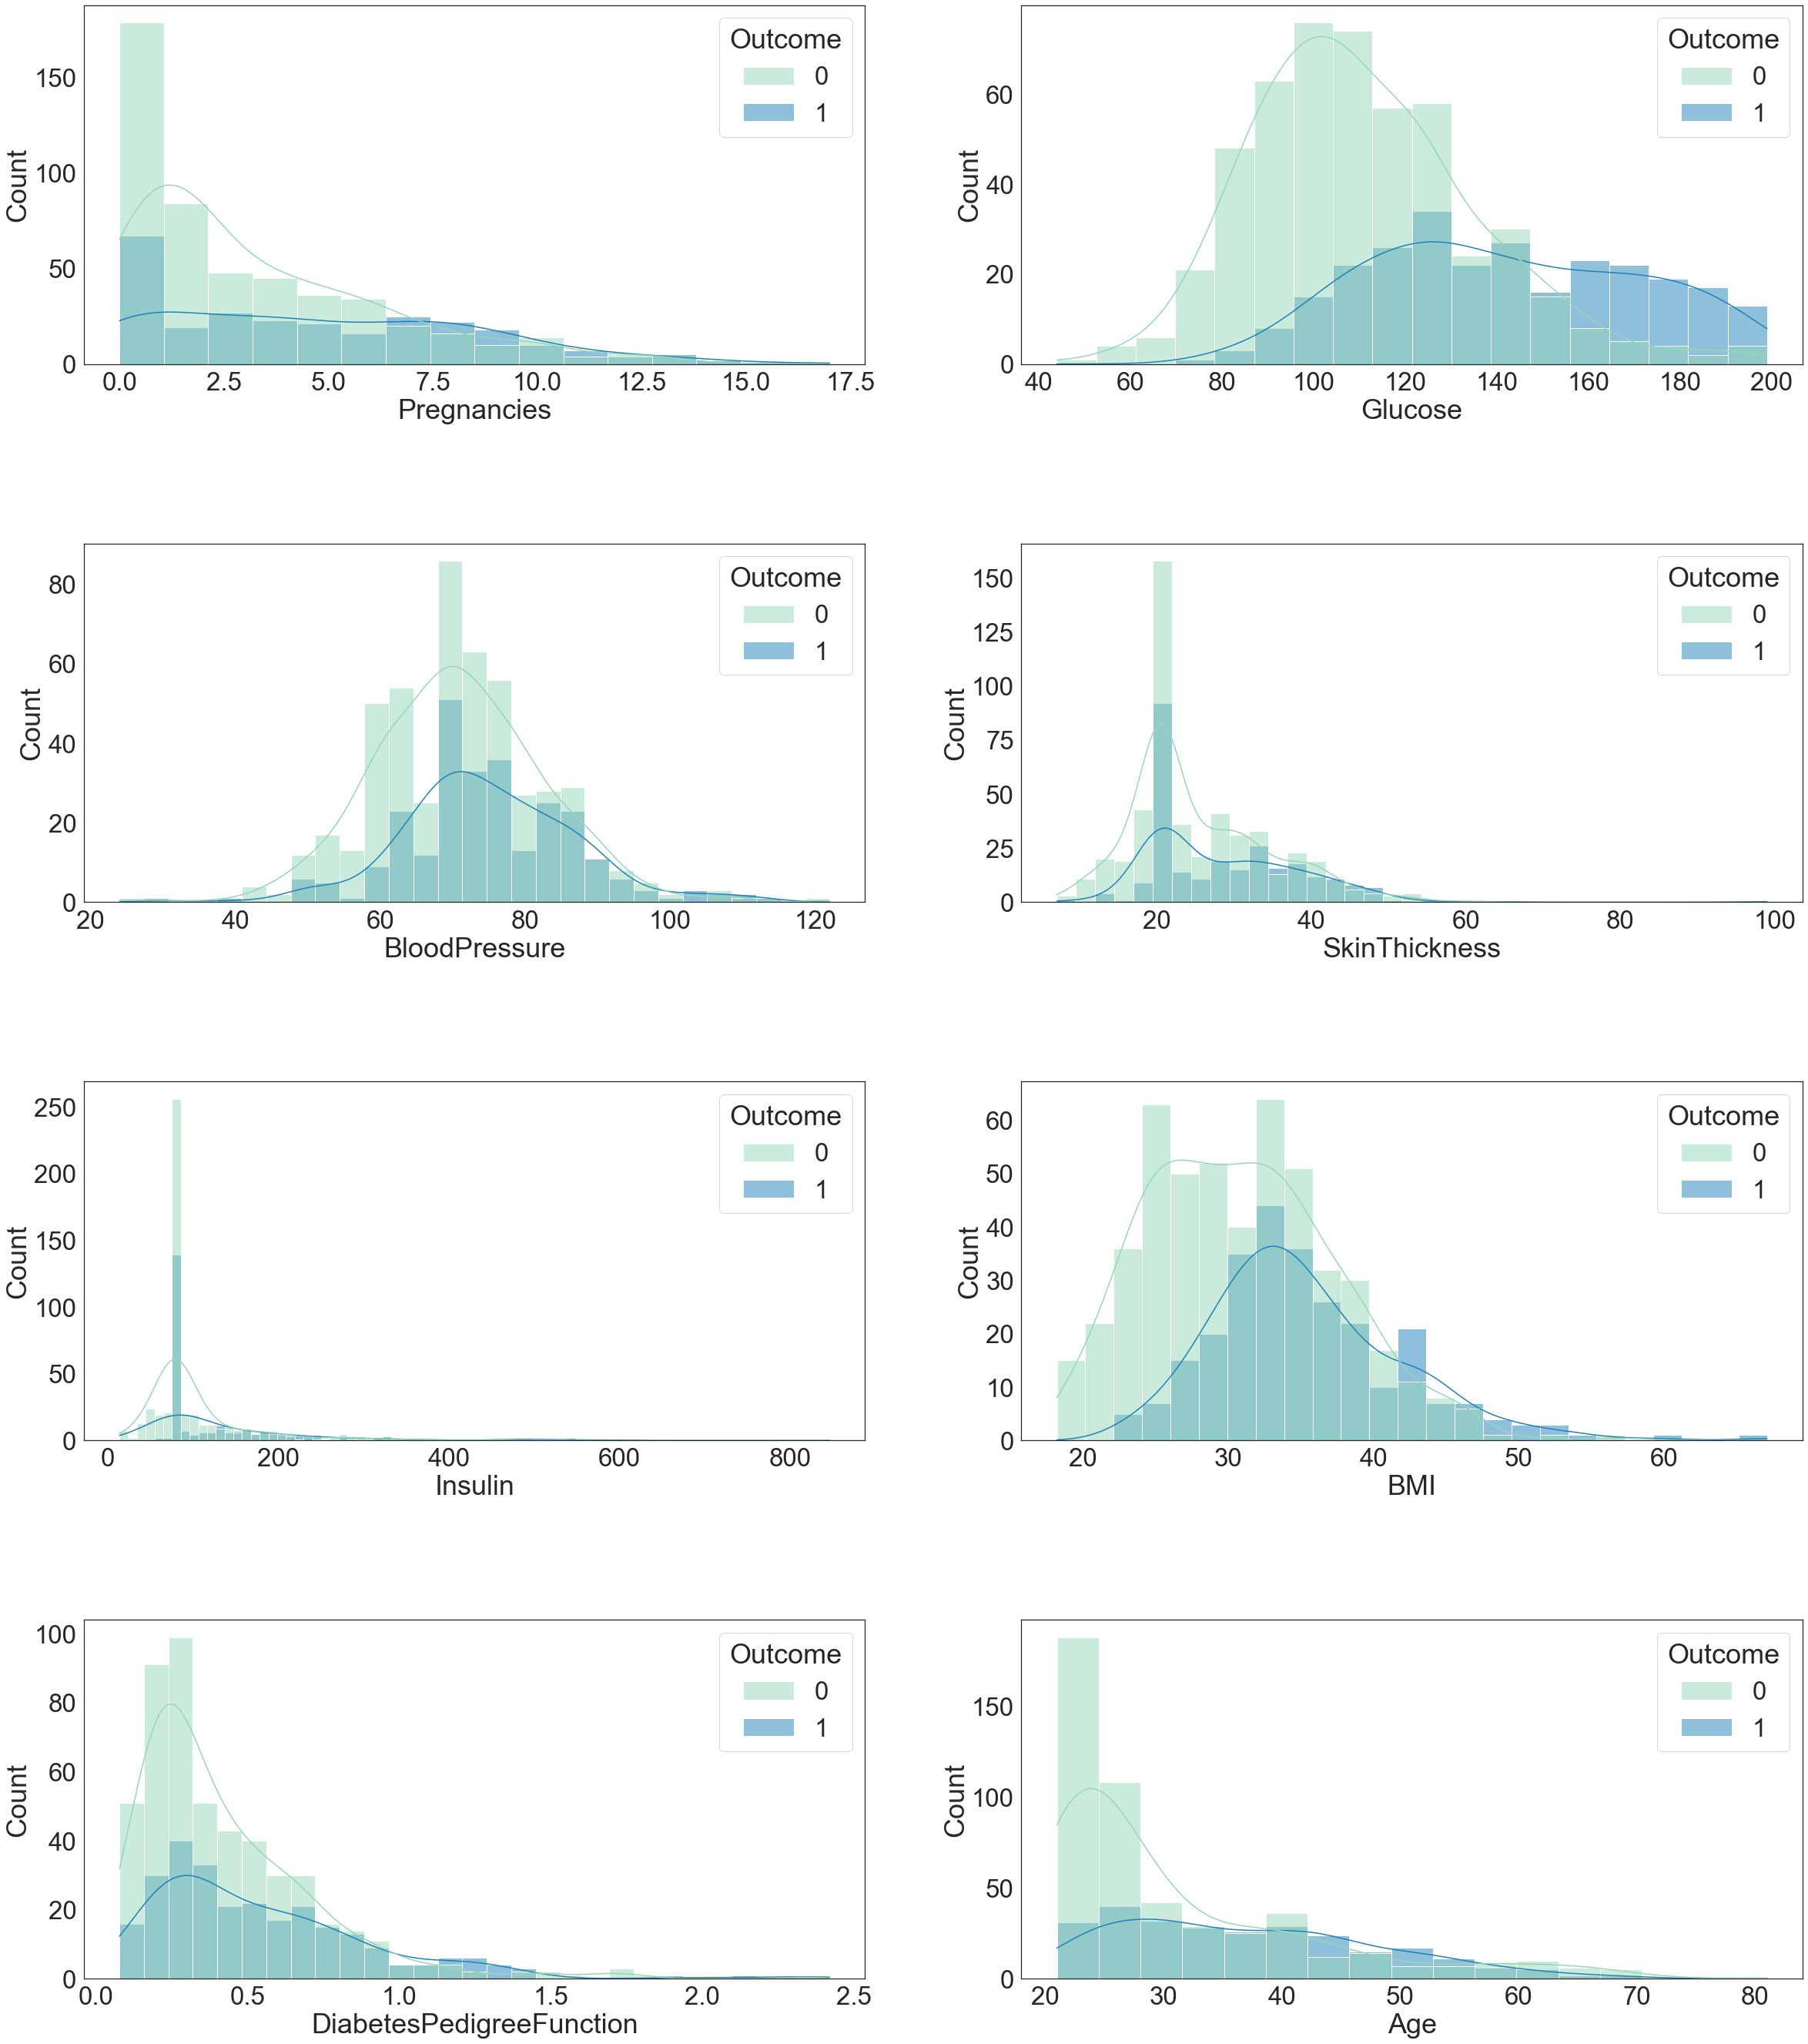

In [102]:
feature_names = [cname for cname in df.loc[:,:'Age'].columns]

plt.rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Looking at the picture above, you can see that the zero value is removed and scaling is done.

## Datavisualization of the dataset

<AxesSubplot: xlabel='Outcome', ylabel='count'>

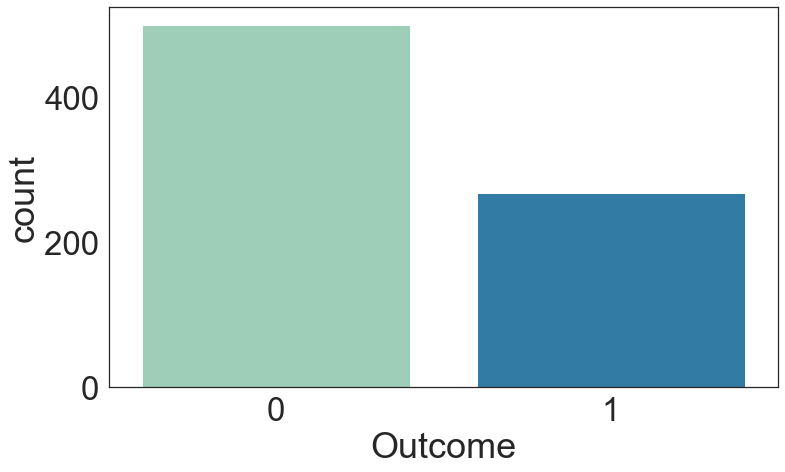

In [103]:
plt.figure(figsize=(12,7))
sns.countplot(x='Outcome', data=df, palette='YlGnBu')

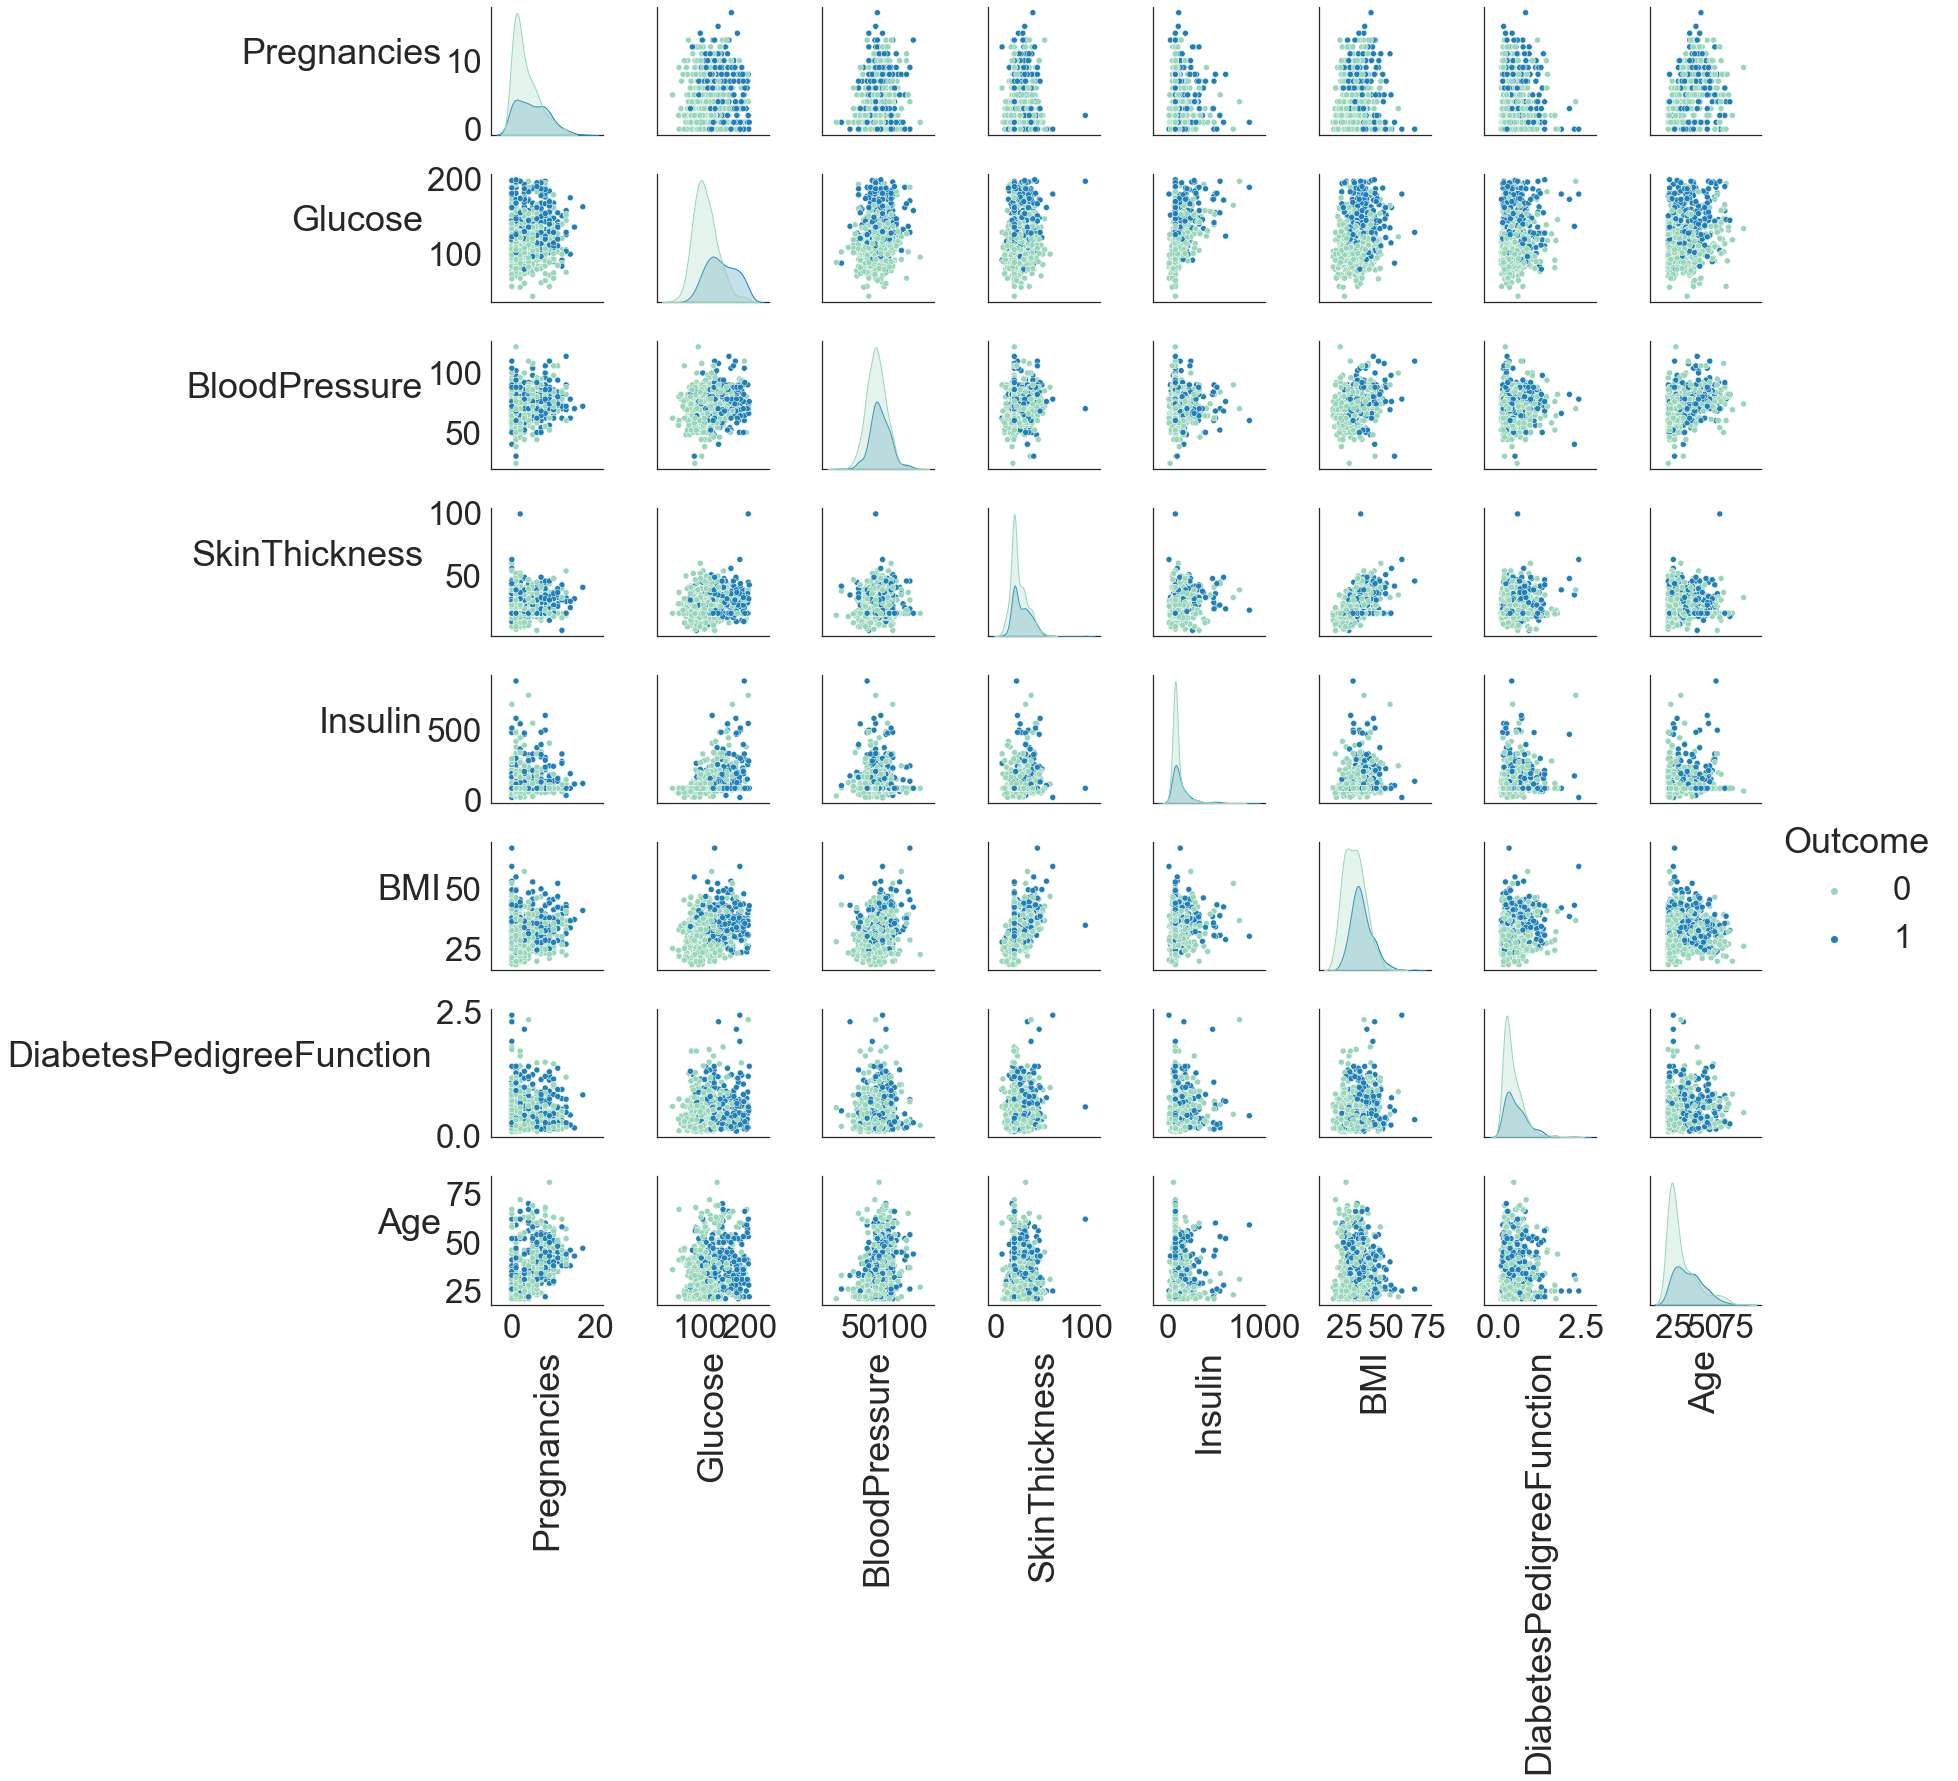

In [104]:
plot_pairplot = sns.pairplot(df, hue='Outcome', palette='YlGnBu',)
for ax in plot_pairplot.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

plot_pairplot

C:\Users\33646\AppData\Local\Temp\ipykernel_15480\1714152714.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


<AxesSubplot: >

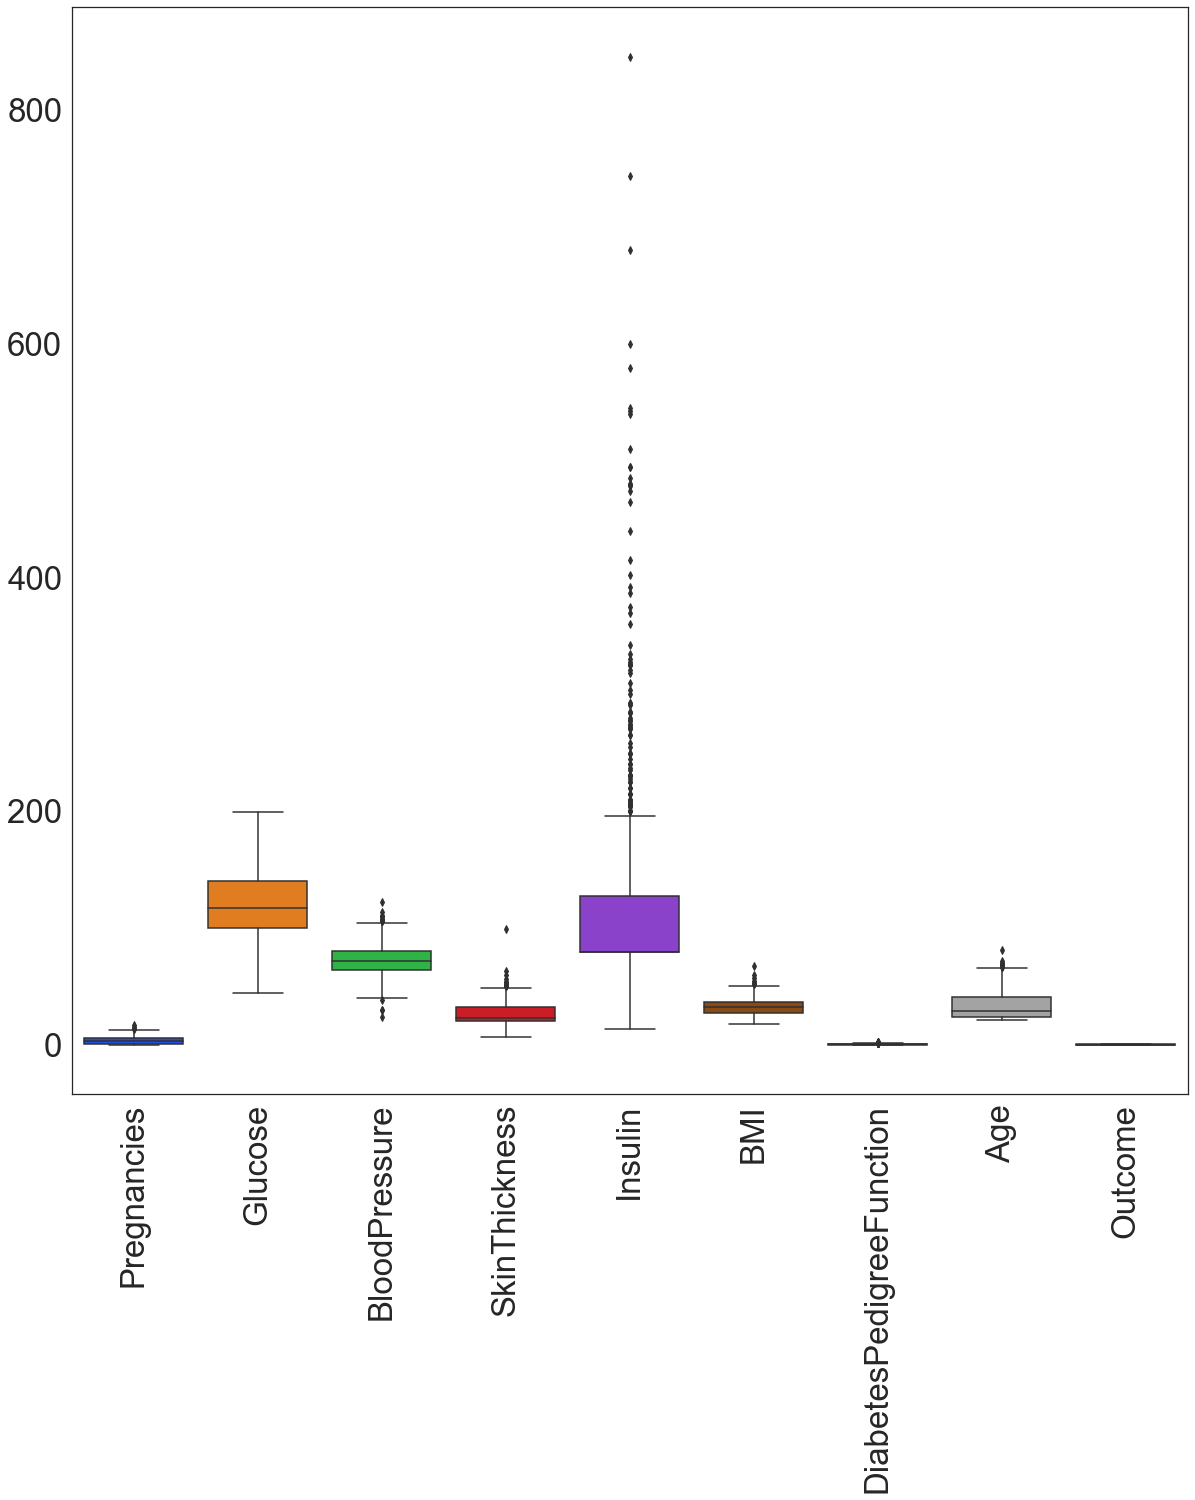

In [105]:
fig , ax = plt.subplots(figsize = (20,20))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.boxplot(data = df, ax = ax)

In [106]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.10)
    quartile3 = dataframe[variable].quantile(0.90)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [107]:
def has_outliers(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print(variable, "has outliers")

In [108]:
for col in df.columns:
    has_outliers(df, col)

SkinThickness has outliers
Insulin has outliers
DiabetesPedigreeFunction has outliers


In [109]:
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [110]:
replace_with_thresholds(df, df.columns)

C:\Users\33646\AppData\Local\Temp\ipykernel_15480\2836366910.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


<AxesSubplot: >

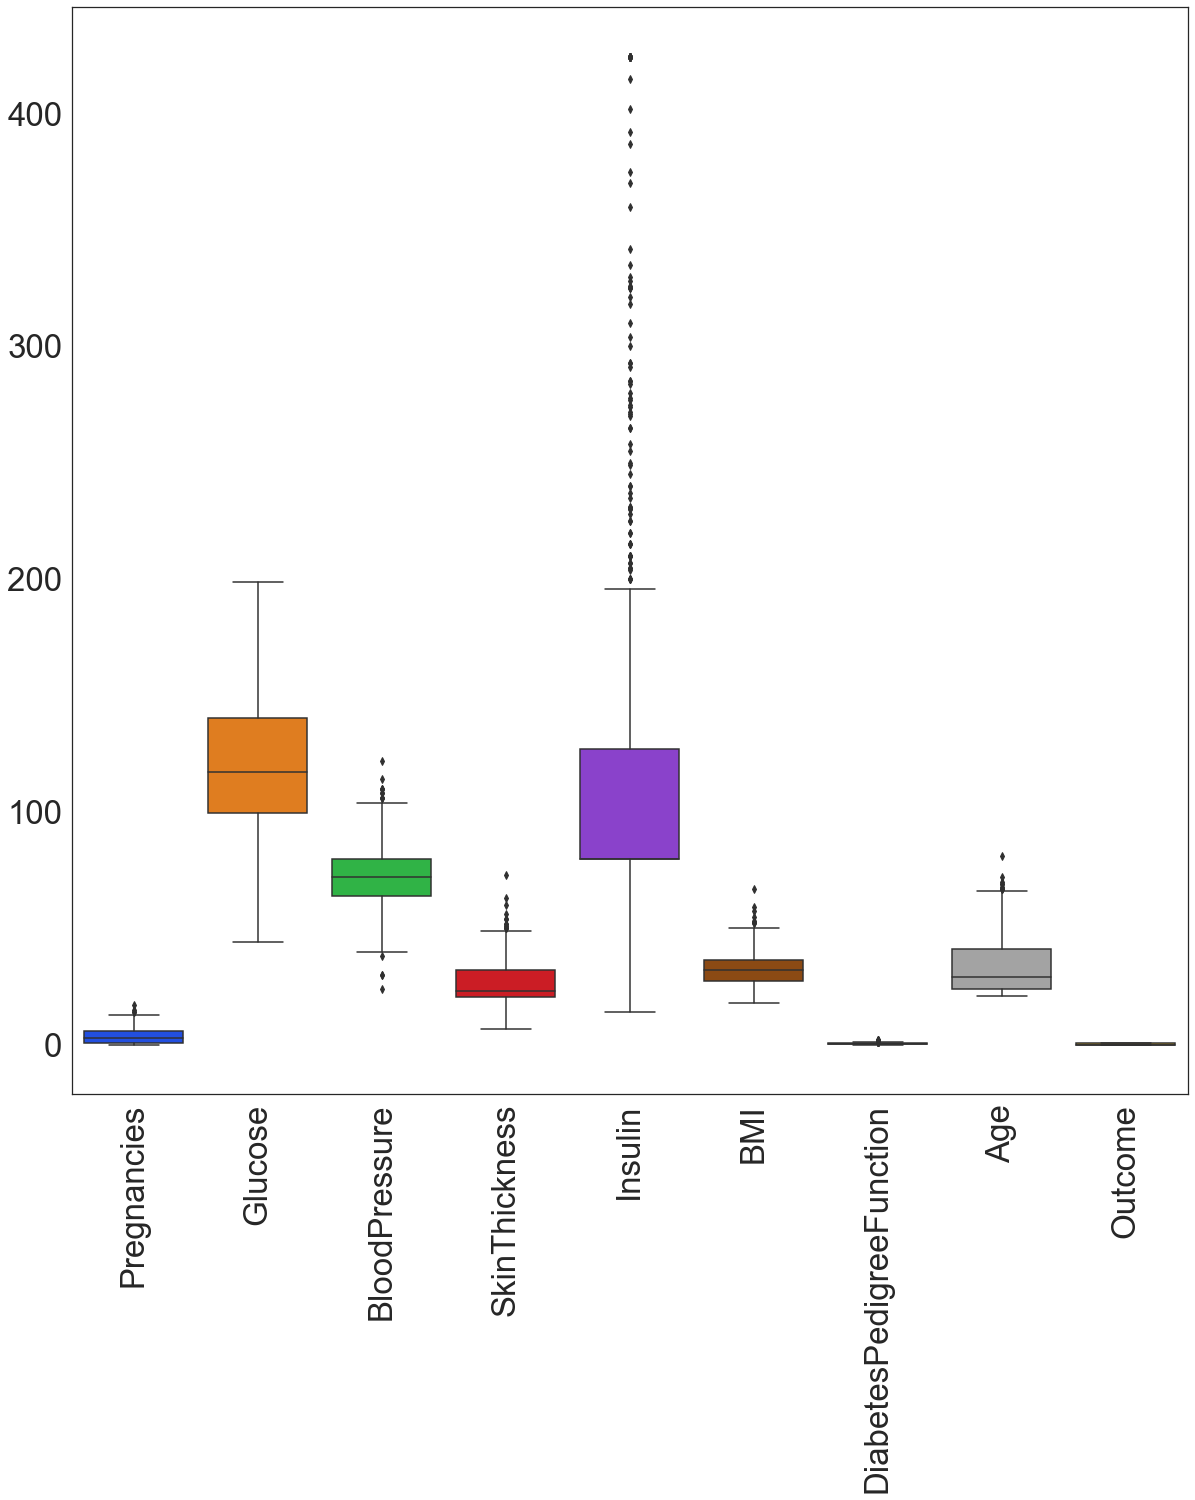

In [111]:
fig , ax = plt.subplots(figsize = (20,20))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.boxplot(data = df, ax = ax)


## Split the data and prepare it for training

In [112]:
X = df.drop(['Outcome'], axis=1)
X = np.array(X)
y = df['Outcome']
y = np.array(y)

In [113]:
#Feature scaling is import for ANN, so let's do it
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.63994726,  0.86527574, -0.0210444 , ...,  0.16725546,
         0.48738112,  1.4259954 ],
       [-0.84488505, -1.20598931, -0.51658286, ..., -0.85153454,
        -0.36986417, -0.19067191],
       [ 1.23388019,  2.01597855, -0.68176235, ..., -1.33182125,
         0.62714937, -0.10558415],
       ...,
       [ 0.3429808 , -0.02240928, -0.0210444 , ..., -0.90975111,
        -0.69909605, -0.27575966],
       [-0.84488505,  0.14197684, -1.01212132, ..., -0.34213954,
        -0.37607609,  1.17073215],
       [-0.84488505, -0.94297153, -0.18622389, ..., -0.29847711,
        -0.48167877, -0.87137393]])

In [114]:
#split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614,) (154,)


Text(0.5, 1.0, 'Correlation Plot')

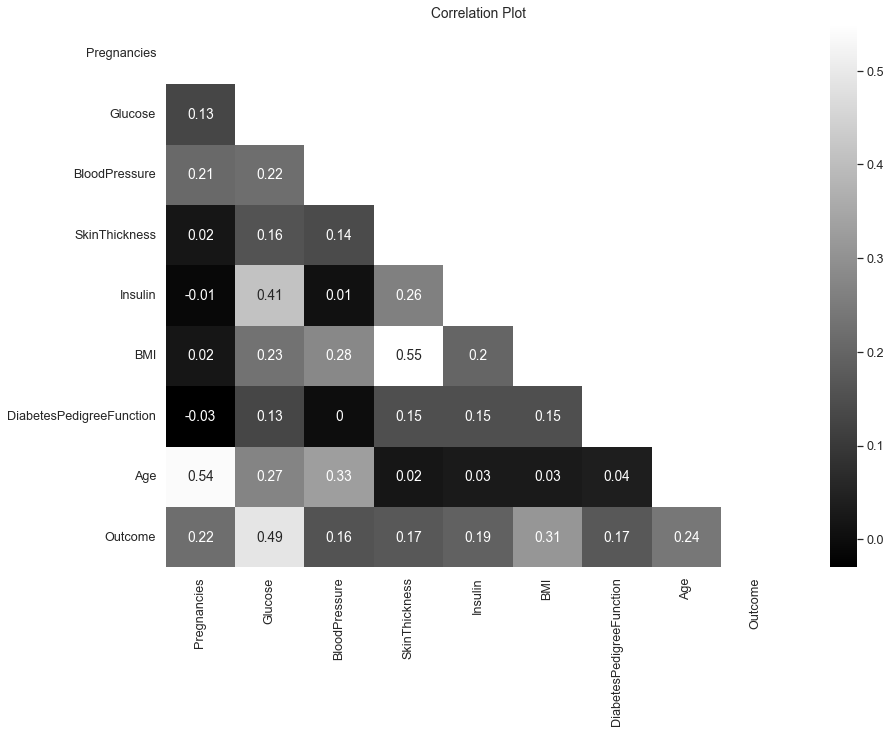

In [29]:
corr=df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

Observation:

- The correlation between Outcome and Glucose is high. Glucose seems to be the most important feature in model training.
- BMI, Pregnancys, and Age are also expected to be used as important features in model training.
- High correlation coefficient with SkinThickness and BMI. There may be a multicollinearity problem, but if there is a performance problem after checking the result, check it again.

## Functions which saves ML models :

In [37]:
def save_model(model, name):
    joblib.dump(model, f'../Model/{name}.pkl')

## Train and evaluate a logistic regression

In the Machine Learning world, Logistic Regression is a kind of parametric classification model, despite having the word ‘regression’ in its name.

Logistic regression is a statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set.

A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables. For example, a logistic regression could be used to predict whether a political candidate will win or lose an election or whether a high school student will be admitted or not to a particular college. These binary outcomes allow straightforward decisions between two alternatives.

Statisticians and citizen data scientists must keep a few assumptions in mind when using logistic regression. For starters, the variables must be independent of one another. So, for example, zip code and gender could be used in a model, but zip code and state would not work.

The maths behind the model are :
$$P(x) = \frac{1}{1+e^{-x}}$$
where P(X) is the probability to be 1.

Other less transparent relationships between variables may get lost in the noise when logistic regression is used as a starting point for complex machine learning and data science applications. For example, data scientists may spend considerable effort to ensure that variables associated with discrimination, such as gender and ethnicity, are not included in the algorithm. However, these can sometimes get indirectly woven into the algorithm via variables that were not thought to be correlated, such as zip code, school or hobbies.

Another assumption is that the raw data should represent unrepeated or independent phenomena. For example, a survey of customer satisfaction should represent the opinions of separate people. But these results would be skewed if someone took the survey multiple times from different email addresses to qualify for a reward.

Advantages :
- Logistic regression is easier to implement, interpret, and very efficient to train.	
- It makes no assumptions about distributions of classes in feature space.
- It can easily extend to multiple classes(multinomial regression) and a natural probabilistic view of class predictions.
- It not only provides a measure of how appropriate a predictor(coefficient size)is, but also its direction of association (positive or negative).
- It is very fast at classifying unknown records.	
- Good accuracy for many simple data sets and it performs well when the dataset is linearly separable.
- It can interpret model coefficients as indicators of feature importance.
- Logistic regression is less inclined to over-fitting but it can overfit in high dimensional datasets.One may consider Regularization (L1 and L2) techniques to avoid over-fittingin these scenarios.

Disadvantages :
- If the number of observations is lesser than the number of features, Logistic Regression should not be used, otherwise, it may lead to overfitting.
- It constructs linear boundaries.
- The major limitation of Logistic Regression is the assumption of linearity between the dependent variable and the independent variables.
- It can only be used to predict discrete functions. Hence, the dependent variable of Logistic Regression is bound to the discrete number set.
- Non-linear problems can’t be solved with logistic regression because it has a linear decision surface. Linearly separable data is rarely found in real-world scenarios.
- Performs well when the dataset is linearly separable.	Logistic Regression requires average or no multicollinearity between independent variables.
- It is tough to obtain complex relationships using logistic regression. More powerful and compact algorithms such as Neural Networks can easily outperform this algorithm.
- In Linear Regression independent and dependent variables are related linearly. But Logistic Regression needs that independent variables are linearly related to the log odds (log(p/(1-p)).

https://www.techtarget.com/searchbusinessanalytics/definition/logistic-regression#:~:text=Logistic%20regression%20is%20a%20statistical,or%20more%20existing%20independent%20variables.

https://towardsdatascience.com/logistic-regression-explained-9ee73cede081

https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/

In [115]:
LR = LogisticRegression(solver='liblinear')
params_LR = {'penalty' : ['l1','l2'],
    'C': np.linspace(0.001,100)}
grid_LR = GridSearchCV(LR, params_LR, cv=10,verbose=True,n_jobs=-1,scoring='recall')
grid_LR.fit(X_train, y_train)
save_model(grid_LR, 'LogisticRegression')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [116]:
y_pred_LR = grid_LR.predict(X_test)

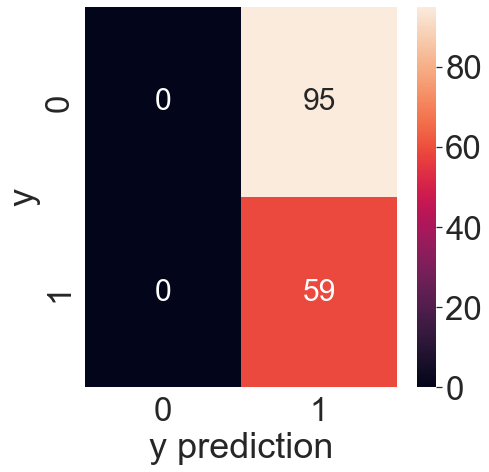

In [117]:
def plot_confusion_matrix(y_pred):
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(7,7)) 
    sns.set(font_scale=3.0)
    sns.heatmap(cm, annot=True, fmt='d',annot_kws={'size': 30})
    plt.xlabel('y prediction')
    plt.ylabel('y')
    plt.show()

plot_confusion_matrix(y_pred_LR)

In [118]:
Results_LR = pd.DataFrame.from_dict({'Model': ['Logistic Regression'], 'Accuracy': [accuracy_score(y_test, y_pred_LR)], 'Precision': [precision_score(y_test, y_pred_LR)], 'Recall': [recall_score(y_test, y_pred_LR)], 'F1': [f1_score(y_test, y_pred_LR)], 'AUC': [roc_auc_score(y_test, y_pred_LR)]})
Results_LR

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.383117,0.383117,1.0,0.553991,0.5


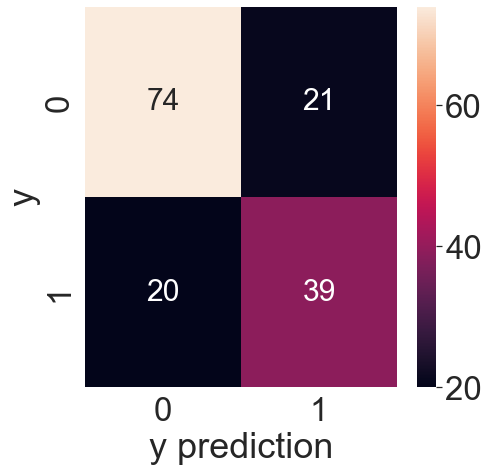

In [52]:
from sklearn.model_selection import cross_val_predict
cv = KFold(n_splits=10, random_state=1, shuffle=True)
LR = LogisticRegression(solver='liblinear', penalty="l2", C=0.001)
y_pred = cross_val_predict(LR, X_test, y_test, cv=10)
plot_confusion_matrix(y_pred)

## Train and evaluate Linear Discriminant Analysis :

Linear Discriminant Analysis is a technique for classifying binary and non-binary features using and linear algorithm for learning the relationship between the dependent and independent features. It uses the Fischer formula to reduce the dimensionality of the data so as to fit in a linear dimension. LDA is a multi-functional algorithm, it is a classifier, dimensionality reducer and data visualizer. The aim of LDA is:

- To minimize the inter-class variability which refers to classifying as many similar points as possible in one class. This ensures fewer misclassifications.
- To maximize the distance between the mean of classes, the mean is placed as far as possible to ensure high confidence during prediction.

LDA makes some assumptions about the data:

- Assumes the data to be distributed normally or Gaussian distribution of data points i.e. each feature must make a bell-shaped curve when plotted. 
- Each of the classes has identical covariance matrices.

However, it is worth mentioning that LDA performs quite well even if the assumptions are violated.

It works on a simple step-by-step basis. Here is an example. These are the three key steps.

$$S_b = \sum_{i=1}^{g}N_i(\bar{x}_i - \bar{x})(\bar{x}_i - \bar{x})^T$$
$$S_W = \sum_{i=1}^g(N_i - 1)S_i =\sum_{i=1}^g\sum_{i=1}^{N_i}N_i(\bar{x}_i - \bar{x})(\bar{x}_i - \bar{x})^T$$
$$P_{lda} = \argmax_{P} \frac{|P^TS_bP|}{|P^TS_wP|}$$

where P is the lower-dimensional space projection. This is also known as Fisher’s criterion.


https://www.digitalvidya.com/blog/linear-discriminant-analysis/

In [56]:
LDA = LinearDiscriminantAnalysis()

params_LDA = dict()
params_LDA['solver'] = ['svd', 'lsqr', 'eigen']
grid_LDA = GridSearchCV(LDA, params_LDA, scoring='accuracy', cv=10, verbose=True,n_jobs=-1)
grid_LDA.fit(X_train, y_train)
grid_LDA.best_params_
save_model(grid_LDA, 'LinearDiscriminantAnalysis')

#https://machinelearningmastery.com/linear-discriminant-analysis-with-python/

Fitting 10 folds for each of 3 candidates, totalling 30 fits


In [57]:
y_pred_LDA = grid_LDA.predict(X_test)

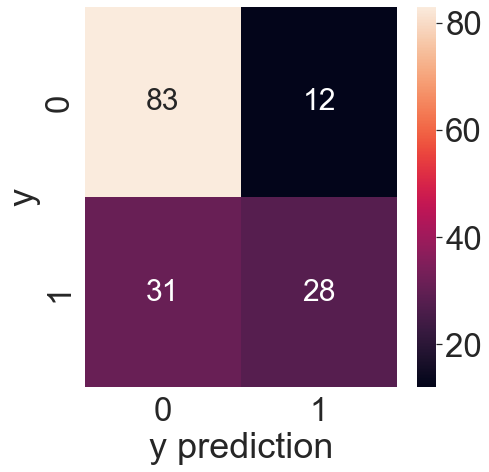

In [58]:
plot_confusion_matrix(y_pred_LDA)

In [59]:
Results_LDA = pd.DataFrame.from_dict({'Model': ['Linear Discriminant analysis'], 'Accuracy': [accuracy_score(y_test, y_pred_LDA)], 'Precision': [precision_score(y_test, y_pred_LDA)], 'Recall': [recall_score(y_test, y_pred_LDA)], 'F1': [f1_score(y_test, y_pred_LDA)], 'AUC': [roc_auc_score(y_test, y_pred_LDA)]})
Results_LDA

,Model,Accuracy,Precision,Recall,F1,AUC
0,Linear Discriminant analysis,0.720779,0.7,0.474576,0.565657,0.67413


## Train and evaluate KNeighbors Classifier :

In statistics, the k-nearest neighbors algorithm (k-NN) is a non-parametric supervised learning method first developed by Evelyn Fix and Joseph Hodges in 1951, and later expanded by Thomas Cover. It is used for classification and regression. In both cases, the input consists of the k closest training examples in a data set. The output depends on whether k-NN is used for classification or regression:

KNN tries to predict the correct class for the test data by calculating the distance between the test data and all the training points. Then select the K number of points which is closet to the test data. The KNN algorithm calculates the probability of the test data belonging to the classes of ‘K’ training data and class holds the highest probability will be selected. In the case of regression, the value is the mean of the ‘K’ selected training points.

In the classification phase, k is a user-defined constant, and an unlabeled vector (a query or test point) is classified by assigning the label which is most frequent among the k training samples nearest to that query point.

The best choice of k depends upon the data; generally, larger values of k reduces effect of the noise on the classification, but make boundaries between classes less distinct. A good k can be selected by various heuristic techniques (see hyperparameter optimization). The special case where the class is predicted to be the class of the closest training sample (i.e. when k = 1) is called the nearest neighbor algorithm.

The accuracy of the k-NN algorithm can be severely degraded by the presence of noisy or irrelevant features, or if the feature scales are not consistent with their importance. Much research effort has been put into selecting or scaling features to improve classification. A particularly popular[citation needed] approach is the use of evolutionary algorithms to optimize feature scaling. Another popular approach is to scale features by the mutual information of the training data with the training classes.[citation needed]

In binary (two class) classification problems, it is helpful to choose k to be an odd number as this avoids tied votes. One popular way of choosing the empirically optimal k in this setting is via bootstrap method.

$$p(class=0) = \frac{count(class=0)}{(count(class=0) +count(class=1))}$$


https://medium.com/swlh/k-nearest-neighbor-ca2593d7a3c4
https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
https://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/

In [64]:
KNN = KNeighborsClassifier()

param_KNN = dict(n_neighbors=list(range(1, 31)))


grid_KNN = GridSearchCV(KNN, param_KNN, scoring='accuracy', cv=10, verbose=True,n_jobs=-1)
grid_KNN.fit(X_train, y_train)
grid_KNN.best_params_
save_model(grid_KNN, 'KNeighborsClassifier')

#https://machinelearningknowledge.ai/knn-classifier-in-sklearn-using-gridsearchcv-with-example/#vii_Model_fitting_with_K-cross_Validation_and_GridSearchCV


Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [62]:
y_pred_KNN = grid_KNN.predict(X_test)

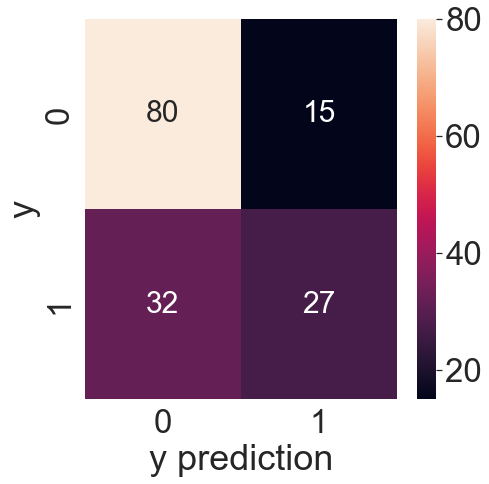

In [63]:
plot_confusion_matrix(y_pred_KNN)

In [65]:
Results_KNN = pd.DataFrame.from_dict({'Model': ['K-Neighbors Classifier'], 'Accuracy': [accuracy_score(y_test, y_pred_KNN)], 'Precision': [precision_score(y_test, y_pred_KNN)], 'Recall': [recall_score(y_test, y_pred_KNN)], 'F1': [f1_score(y_test, y_pred_KNN)], 'AUC': [roc_auc_score(y_test, y_pred_KNN)]})
Results_KNN

,Model,Accuracy,Precision,Recall,F1,AUC
0,K-Neighbors Classifier,0.694805,0.642857,0.457627,0.534653,0.649866


## Train and evaluate Decision Tree Classifier :

Decision Tree is a Supervised Machine Learning Algorithm that uses a set of rules to make decisions, similarly to how humans make decisions.

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

The intuition behind Decision Trees is that you use the dataset features to create yes/no questions and continually split the dataset until you isolate all data points belonging to each class.

The ideal tree is the smallest tree possible, i.e. with fewer splits, that can accurately classify all data points.

On every split, the algorithm tries to divide the dataset into the smallest subset possible[2]. So, like any other Machine Learning algorithm, the goal is to minimize the loss function as much as possible.

But since you’re separating data points that belong to different classes, the loss function should evaluate a split based on the proportion of data points belonging to each class before and after the split.

Some advantages of decision trees are:
- Simple to understand and to interpret. Trees can be visualized.
- Requires little data preparation. Other techniques often require data normalization, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.
- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
- Able to handle both numerical and categorical data. However, the scikit-learn implementation does not support categorical variables for now. Other techniques are usually specialized in analyzing datasets that have only one type of variable. See algorithms for more information.
- Able to handle multi-output problems.
- Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
- Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.

The disadvantages of decision trees include:

- Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
- Predictions of decision trees are neither smooth nor continuous, but piecewise constant approximations as seen in the above figure. Therefore, they are not good at extrapolation.
- The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.
- There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems.
- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.


https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575
https://scikit-learn.org/stable/modules/tree.html


In [65]:
DTC = DecisionTreeClassifier()

param_DTC = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

grid_DTC = GridSearchCV(DTC, param_DTC, scoring='accuracy', cv=10, verbose=True,n_jobs=-1)
grid_DTC.fit(X_train, y_train)
grid_DTC.best_params_
save_model(grid_DTC, 'DecisionTreeClassifier')

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [66]:
y_pred_DTC = grid_DTC.predict(X_test)

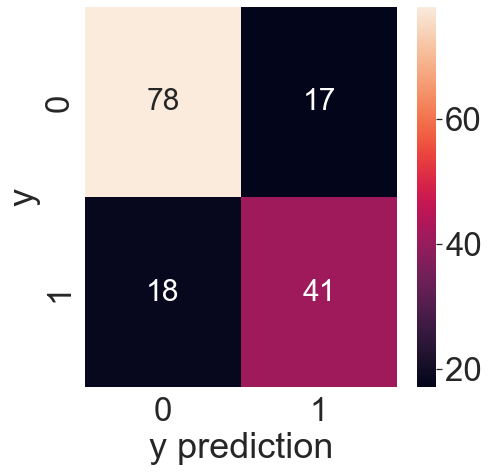

In [67]:
plot_confusion_matrix(y_pred_DTC)

In [68]:
Results_DTC = pd.DataFrame.from_dict({'Model': ['Decision Tree Classifier'], 'Accuracy': [accuracy_score(y_test, y_pred_DTC)], 'Precision': [precision_score(y_test, y_pred_DTC)], 'Recall': [recall_score(y_test, y_pred_DTC)], 'F1': [f1_score(y_test, y_pred_DTC)], 'AUC': [roc_auc_score(y_test, y_pred_DTC)]})
Results_DTC

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree Classifier,0.772727,0.706897,0.694915,0.700855,0.757984


## Train and evaluate Random Forest Classifier : 

Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification and Regression problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.

One of the most important features of the Random Forest Algorithm is that it can handle the data set containing continuous variables as in the case of regression and categorical variables as in the case of classification. It performs better results for classification problems.

Ensemble uses two types of methods:

-  Bagging– It creates a different training subset from sample training data with replacement & the final output is based on majority voting. For example,  Random Forest.
- Boosting– It combines weak learners into strong learners by creating sequential models such that the final model has the highest accuracy. For example,  ADA BOOST, XG BOOST

Bagging, also known as Bootstrap Aggregation is the ensemble technique used by random forest. Bagging chooses a random sample from the data set. Hence each model is generated from the samples (Bootstrap Samples) provided by the Original Data with replacement known as row sampling. This step of row sampling with replacement is called bootstrap. Now each model is trained independently which generates results. The final output is based on majority voting after combining the results of all models. This step which involves combining all the results and generating output based on majority voting is known as aggregation.

Random Forest Algorithm Advantages and Disadvantages
Advantages :
- One of the biggest advantages of random forest is its versatility. It can be used for both regression and classification tasks, and it’s also easy to view the relative importance it assigns to the input features.
- Random forest is also a very handy algorithm because the default hyperparameters it uses often produce a good prediction result. Understanding the hyperparameters is pretty straightforward, and there’s also not that many of them. 
- One of the biggest problems in machine learning is overfitting, but most of the time this won’t happen thanks to the random forest classifier. If there are enough trees in the forest, the classifier won’t overfit the model.

Disadvantages :
- The main limitation of random forest is that a large number of trees can make the algorithm too slow and ineffective for real-time predictions. In general, these algorithms are fast to train, but quite slow to create predictions once they are trained. A more accurate prediction requires more trees, which results in a slower model. In most real-world applications, the random forest algorithm is fast enough but there can certainly be situations where run-time performance is important and other approaches would be preferred.
- And, of course, random forest is a predictive modeling tool and not a descriptive tool, meaning if you’re looking for a description of the relationships in your data, other approaches would be better.


https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/
https://builtin.com/data-science/random-forest-algorithm

In [69]:
RFC = RandomForestClassifier(n_estimators=300)
paramsRFC = { 'max_depth' : range(5,20),
          'min_samples_split' : np.arange(2,10)
}
grid_RFC = GridSearchCV(RFC, paramsRFC, cv=10,verbose=True,n_jobs=-1,scoring='accuracy')
grid_RFC.fit(X_train,y_train)
grid_RFC.best_params_
save_model(grid_RFC, 'RandomForestClassifier')

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


In [70]:
y_pred_RFC = grid_RFC.predict(X_test)

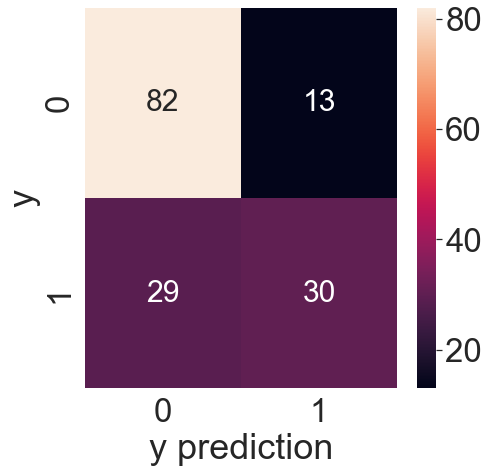

In [71]:
plot_confusion_matrix(y_pred_RFC)

In [72]:
Results_RFC = pd.DataFrame.from_dict({'Model': ['Random Forest Classifier'], 'Accuracy': [accuracy_score(y_test, y_pred_RFC)], 'Precision': [precision_score(y_test, y_pred_RFC)], 'Recall': [recall_score(y_test, y_pred_RFC)], 'F1': [f1_score(y_test, y_pred_RFC)], 'AUC': [roc_auc_score(y_test, y_pred_RFC)]})
Results_RFC

,Model,Accuracy,Precision,Recall,F1,AUC
0,Random Forest Classifier,0.727273,0.697674,0.508475,0.588235,0.685816


## Train and evaluate a gaussian NB :

Naive Bayes are a group of supervised machine learning classification algorithms based on the Bayes theorem. It is a simple classification technique, but has high functionality. They find use when the dimensionality of the inputs is high. Complex classification problems can also be implemented by using Naive Bayes Classifier.

Naive Bayes Classifiers are based on the Bayes Theorem. 
One assumption taken is the strong independence assumptions between the features. These classifiers assume that the value of a particular feature is independent of the value of any other feature. In a supervised learning situation, Naive Bayes Classifiers are trained very efficiently. Naive Bayed classifiers need a small training data to estimate the parameters needed for classification. Naive Bayes Classifiers have simple design and implementation and they can applied to many real life situations.


https://iq.opengenus.org/gaussian-naive-bayes/#:~:text=Gaussian%20Naive%20Bayes%20supports%20continuous,(independent%20dimensions)%20between%20dimensions.

In [73]:
GNB = GaussianNB()

paramsGNB = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_GNB = GridSearchCV(GNB, paramsGNB, cv=10,verbose=True,n_jobs=-1,scoring='accuracy')
grid_GNB.fit(X_train,y_train)
grid_GNB.best_params_
save_model(grid_GNB, 'GaussianNB')

#https://stackoverflow.com/questions/44974207/in-gridsearchcv-how-do-i-pass-only-the-default-parameters-in-param-grid

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [74]:
y_pred_GNB = grid_GNB.predict(X_test)

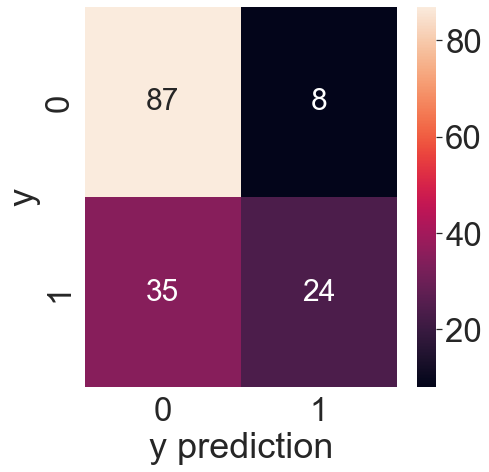

In [75]:
plot_confusion_matrix(y_pred_GNB)

In [76]:
Results_GNB = pd.DataFrame.from_dict({'Model': ['Gaussian NB'], 'Accuracy': [accuracy_score(y_test, y_pred_GNB)], 'Precision': [precision_score(y_test, y_pred_GNB)], 'Recall': [recall_score(y_test, y_pred_GNB)], 'F1': [f1_score(y_test, y_pred_GNB)], 'AUC': [roc_auc_score(y_test, y_pred_GNB)]})
Results_GNB

,Model,Accuracy,Precision,Recall,F1,AUC
0,Gaussian NB,0.720779,0.75,0.40678,0.527473,0.661285


## Train and evaluate a Suport vector machine :

SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes.

At first approximation what SVMs do is to find a separating line(or hyperplane) between data of two classes. SVM is an algorithm that takes the data as an input and outputs a line that separates those classes if possible.

According to the SVM algorithm we find the points closest to the line from both the classes.These points are called support vectors. Now, we compute the distance between the line and the support vectors. This distance is called the margin. Our goal is to maximize the margin. The hyperplane for which the margin is maximum is the optimal hyperplane.

Advantages :
- Accuracy
- Works well on smaller cleaner datasets
- It can be more efficient because it uses a subset of training points

Disadvantages :
- Isn’t suited to larger datasets as the training time with SVMs can be high
- Less effective on noisier datasets with overlapping classes

https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989
https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html

In [77]:
from sklearn.svm import LinearSVC

SVC_model = LinearSVC(max_iter=10000)

params = {'C': np.linspace(0.001,100)}
grid_SVC = GridSearchCV(SVC_model, params, cv=5,verbose=True,n_jobs=-1,scoring='accuracy')
grid_SVC.fit(X_test,y_test)
grid_SVC.best_params_
save_model(grid_SVC, 'LinearSVC')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\33646\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [78]:
y_pred_SVC = grid_SVC.predict(X_test)

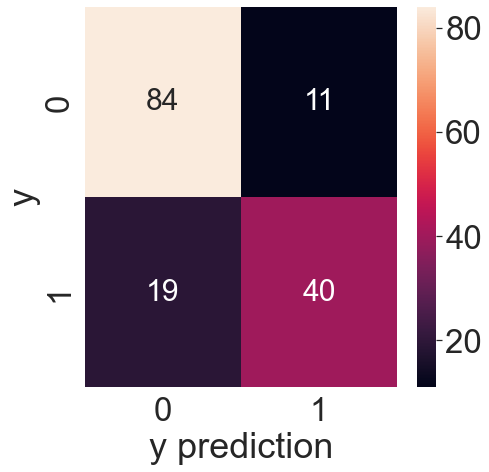

In [79]:
plot_confusion_matrix(y_pred_SVC)

In [85]:
Results_SVC = pd.DataFrame.from_dict({'Model': ['Support Vector Machine'], 'Accuracy': [accuracy_score(y_test, y_pred_SVC)], 'Precision': [precision_score(y_test, y_pred_SVC)], 'Recall': [recall_score(y_test, y_pred_SVC)], 'F1': [f1_score(y_test, y_pred_SVC)], 'AUC': [roc_auc_score(y_test, y_pred_SVC)]})
Results_SVC

,Model,Accuracy,Precision,Recall,F1,AUC
0,Support Vector Machine,0.805195,0.784314,0.677966,0.727273,0.781088


## Train and evaluate Gradient Boosting Classifier

Gradient boosting is a machine learning technique used in regression and classification tasks, among others. It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient-boosted trees; it usually outperforms random forest. A gradient-boosted trees model is built in a stage-wise fashion as in other boosting methods, but it generalizes the other methods by allowing optimization of an arbitrary differentiable loss function.

Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm. This gives the technique its name, “gradient boosting,” as the loss gradient is minimized as the model is fit, much like a neural network.

There are three types of enhancements to basic gradient boosting that can improve performance:

- Tree Constraints: such as the depth of the trees and the number of trees used in the ensemble.
- Weighted Updates: such as a learning rate used to limit how much each tree contributes to the ensemble.
- Random sampling: such as fitting trees on random subsets of features and samples.

In [80]:
GBC = GradientBoostingClassifier()

paramsGBC = {'learning_rate':[0.01, 0.05, 0.1, 0.5, 1],  
              'min_samples_split':[2,5,10,20], 
              'max_depth':[2,3,5,10]}

grid_GBC = GridSearchCV(GBC, paramsGBC, cv=10,verbose=True,n_jobs=-1,scoring='accuracy')
grid_GBC.fit(X_train,y_train)
grid_GBC.best_params_
save_model(grid_GBC, 'GradientBoostingClassifier')
#https://stackoverflow.com/questions/43530761/cross-validation-with-grid-search-returns-worse-results-than-default

Fitting 10 folds for each of 80 candidates, totalling 800 fits


In [81]:
y_pred_GBC = grid_GBC.predict(X_test)

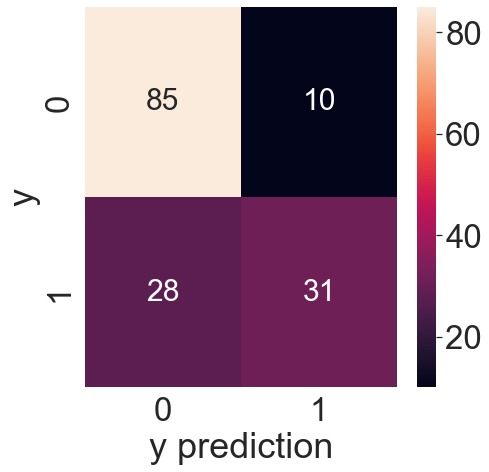

In [82]:
plot_confusion_matrix(y_pred_GBC)

In [90]:
Results_GBC = pd.DataFrame.from_dict({'Model': ['Gradient Boosting Classifier'], 'Accuracy': [accuracy_score(y_test, y_pred_GBC)], 'Precision': [precision_score(y_test, y_pred_GBC)], 'Recall': [recall_score(y_test, y_pred_GBC)], 'F1': [f1_score(y_test, y_pred_GBC)], 'AUC': [roc_auc_score(y_test, y_pred_GBC)]})
Results_GBC

,Model,Accuracy,Precision,Recall,F1,AUC
0,Gradient Boosting Classifier,0.753247,0.756098,0.525424,0.62,0.71008


## Train and evaluate LGBMClassifier

Light GBM is a gradient boosting framework that uses tree based learning algorithm.

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

It has become difficult for the traditional algorithms to give results fast, as the size of the data is increasing rapidly day by day. LightGBM is called “Light” because of its computation power and giving results faster. It takes less memory to run and is able to deal with large amounts of data. Most widely used algorithm in Hackathons because the motive of the algorithm is to get good accuracy of results and also brace GPU leaning.



https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

https://www.analyticssteps.com/blogs/what-light-gbm-algorithm-how-use-it

In [84]:
LGBMC = LGBMClassifier()

paramsLGBMC = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
    }

grid_LGBMC = GridSearchCV(LGBMC, paramsLGBMC, cv=10,verbose=True,n_jobs=-1,scoring='accuracy')
grid_LGBMC.fit(X_train,y_train)
save_model(grid_LGBMC, 'LGBMClassifier')
grid_LGBMC.best_params_

Fitting 10 folds for each of 2916 candidates, totalling 29160 fits


{'colsample_bytree': 0.7,
 'max_depth': 15,
 'min_split_gain': 0.4,
 'n_estimators': 400,
 'num_leaves': 50,
 'reg_alpha': 1.1,
 'reg_lambda': 1.3,
 'subsample': 0.8,
 'subsample_freq': 20}

In [85]:
y_pred_LGBMC = grid_LGBMC.predict(X_test)

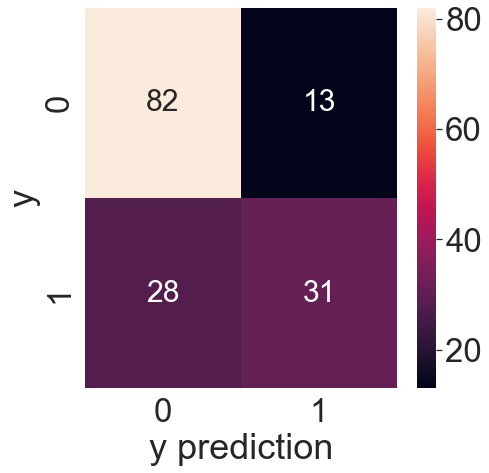

In [86]:
plot_confusion_matrix(y_pred_LGBMC)

In [87]:
Results_LGBMC = pd.DataFrame.from_dict({'Model': ['LightGBM Classifier'], 'Accuracy': [accuracy_score(y_test, y_pred_LGBMC)], 'Precision': [precision_score(y_test, y_pred_LGBMC)], 'Recall': [recall_score(y_test, y_pred_LGBMC)], 'F1': [f1_score(y_test, y_pred_LGBMC)], 'AUC': [roc_auc_score(y_test, y_pred_LGBMC)]})
Results_LGBMC

,Model,Accuracy,Precision,Recall,F1,AUC
0,LightGBM Classifier,0.733766,0.704545,0.525424,0.601942,0.694291


## Train and evaluate XGB Classifier :

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

The implementation of the model supports the features of the scikit-learn and R implementations, with new additions like regularization. Three main forms of gradient boosting are supported:

- Gradient Boosting algorithm also called gradient boosting machine including the learning rate.
- Stochastic Gradient Boosting with sub-sampling at the row, column and column per split levels.
- Regularized Gradient Boosting with both L1 and L2 regularization.



https://www.nvidia.com/en-us/glossary/data-science/xgboost/#:~:text=XGBoost%2C%20which%20stands%20for%20Extreme,%2C%20classification%2C%20and%20ranking%20problems.



In [88]:
XGB = XGBClassifier()

paramsXGB = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

grid_XGB = GridSearchCV(XGB, paramsXGB, cv=10,verbose=True,n_jobs=-1,scoring='accuracy')
grid_XGB.fit(X_train,y_train)
save_model(grid_XGB, 'XGBClassifier')
grid_XGB.best_params_


Fitting 10 folds for each of 405 candidates, totalling 4050 fits


{'colsample_bytree': 1.0,
 'gamma': 2,
 'max_depth': 3,
 'min_child_weight': 10,
 'subsample': 1.0}

In [89]:
y_pred_XGB = grid_XGB.predict(X_test)

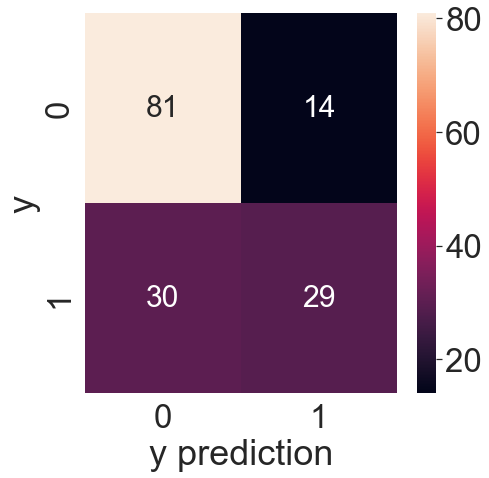

In [90]:
plot_confusion_matrix(y_pred_XGB)

In [91]:
Results_XGB = pd.DataFrame.from_dict({'Model': ['XG-Boost Classifier'], 'Accuracy': [accuracy_score(y_test, y_pred_XGB)], 'Precision': [precision_score(y_test, y_pred_XGB)], 'Recall': [recall_score(y_test, y_pred_XGB)], 'F1': [f1_score(y_test, y_pred_XGB)], 'AUC': [roc_auc_score(y_test, y_pred_XGB)]})
Results_XGB

,Model,Accuracy,Precision,Recall,F1,AUC
0,XG-Boost Classifier,0.714286,0.674419,0.491525,0.568627,0.672079


## Train and evaluate MLP classifier

The multilayer perceptron (MLP) is a feedforward artificial neural network model that maps input data sets to a set of appropriate outputs. An MLP consists of multiple layers and each layer is fully connected to the following one. The nodes of the layers are neurons with nonlinear activation functions, except for the nodes of the input layer. Between the input and the output layer there may be one or more nonlinear hidden layers.

In [92]:
MLP = MLPClassifier()
paramsMLP = {'solver': ['lbfgs'], 'max_iter': [1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
grid_MLP = GridSearchCV(MLP, paramsMLP, n_jobs=-1)
grid_MLP.fit(X_train,y_train)
save_model(grid_MLP, 'MLPClassifier')
grid_MLP.best_params_

{'alpha': 1e-08,
 'hidden_layer_sizes': 10,
 'max_iter': 1000,
 'random_state': 8,
 'solver': 'lbfgs'}

In [ ]:
y_pred_MLP = grid_MLP.predict(X_test)

In [ ]:
plot_confusion_matrix(y_pred_MLP)

In [ ]:
Results_MLP = pd.DataFrame.from_dict({'Model': ['MLP Classifier'], 'Accuracy': [accuracy_score(y_test, y_pred_MLP)], 'Precision': [precision_score(y_test, y_pred_MLP)], 'Recall': [recall_score(y_test, y_pred_MLP)], 'F1': [f1_score(y_test, y_pred_MLP)], 'AUC': [roc_auc_score(y_test, y_pred_MLP)]})
Results_MLP

## Build a neural network model with Tensorflow and Keras



In [196]:
ANN_model = tf.keras.models.Sequential()
ANN_model.add(tf.keras.layers.Dense(units=400, activation='relu', input_shape=(8,)))
ANN_model.add(tf.keras.layers.Dropout(0.2))

ANN_model.add(tf.keras.layers.Dense(units=400, activation='relu'))
ANN_model.add(tf.keras.layers.Dropout(0.2))

ANN_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

ANN_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 400)               3600      
                                                                 
 dropout_10 (Dropout)        (None, 400)               0         
                                                                 
 dense_16 (Dense)            (None, 400)               160400    
                                                                 
 dropout_11 (Dropout)        (None, 400)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 401       
                                                                 
Total params: 164,401
Trainable params: 164,401
Non-trainable params: 0
_________________________________________________________________


Compile and train the ANN model

In [197]:
ANN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #We use binary_crossentropy because we have binary outcome

ANN_model.fit(X_train, y_train, epochs=200)



Epoch 1/200
20/20 [==============================] - 4s 4ms/step - loss: 0.5184 - accuracy: 0.7329
Epoch 2/200
20/20 [==============================] - 0s 4ms/step - loss: 0.4633 - accuracy: 0.7899
Epoch 3/200
20/20 [==============================] - 0s 4ms/step - loss: 0.4441 - accuracy: 0.7801
Epoch 4/200
20/20 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.7932
Epoch 5/200
20/20 [==============================] - 0s 5ms/step - loss: 0.4208 - accuracy: 0.7964
Epoch 6/200
20/20 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.7915
Epoch 7/200
20/20 [==============================] - 0s 3ms/step - loss: 0.4117 - accuracy: 0.8094
Epoch 8/200
20/20 [==============================] - 0s 4ms/step - loss: 0.4083 - accuracy: 0.8029
Epoch 9/200
20/20 [==============================] - 0s 6ms/step - loss: 0.4005 - accuracy: 0.8078
Epoch 10/200
20/20 [==============================] - 0s 3ms/step - loss: 0.3998 - accuracy: 0.8208
Epoch 11/

In [198]:
ANN_model.save('../Model/ANN_model.h5')

In [199]:
ANN_model =  tf.keras.models.load_model('../Model/ANN_model.h5')

Assessment of the model

In [200]:
#So we'll first predict on the X_test
y_pred_ANN = ANN_model.predict(X_test)
y_pred_ANN

5/5 [==============================] - 5s 2ms/step


array([[9.49374437e-01],
       [5.56436926e-02],
       [1.18536071e-03],
       [4.17810101e-12],
       [1.09969013e-04],
       [1.83414101e-20],
       [5.04993769e-10],
       [9.32662129e-01],
       [2.00013575e-10],
       [9.63750362e-01],
       [1.46434630e-07],
       [8.27631295e-01],
       [1.00000000e+00],
       [9.50843582e-09],
       [2.43588627e-04],
       [9.95680451e-01],
       [1.00000000e+00],
       [3.64269717e-08],
       [8.72344948e-13],
       [3.04324031e-01],
       [7.66756773e-01],
       [8.63744974e-01],
       [1.85374574e-05],
       [7.84346044e-01],
       [4.02147928e-03],
       [9.99890387e-01],
       [1.04188009e-08],
       [9.75440070e-03],
       [2.53824401e-04],
       [9.95153666e-01],
       [7.22368077e-06],
       [9.61721371e-13],
       [2.79428282e-13],
       [9.98032879e-10],
       [1.76115438e-01],
       [1.66666303e-09],
       [8.12915317e-08],
       [3.75321686e-01],
       [9.93799090e-01],
       [1.02063455e-10],


In [201]:
#Now we'll convert the probabilities into 0 and 1
y_pred_ANN = np.where(y_pred_ANN >= 0.5, 1, 0)
y_pred_ANN


array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
    

Evaluate trained model

In [202]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

Text(0, 0.5, 'Training and validation loss')

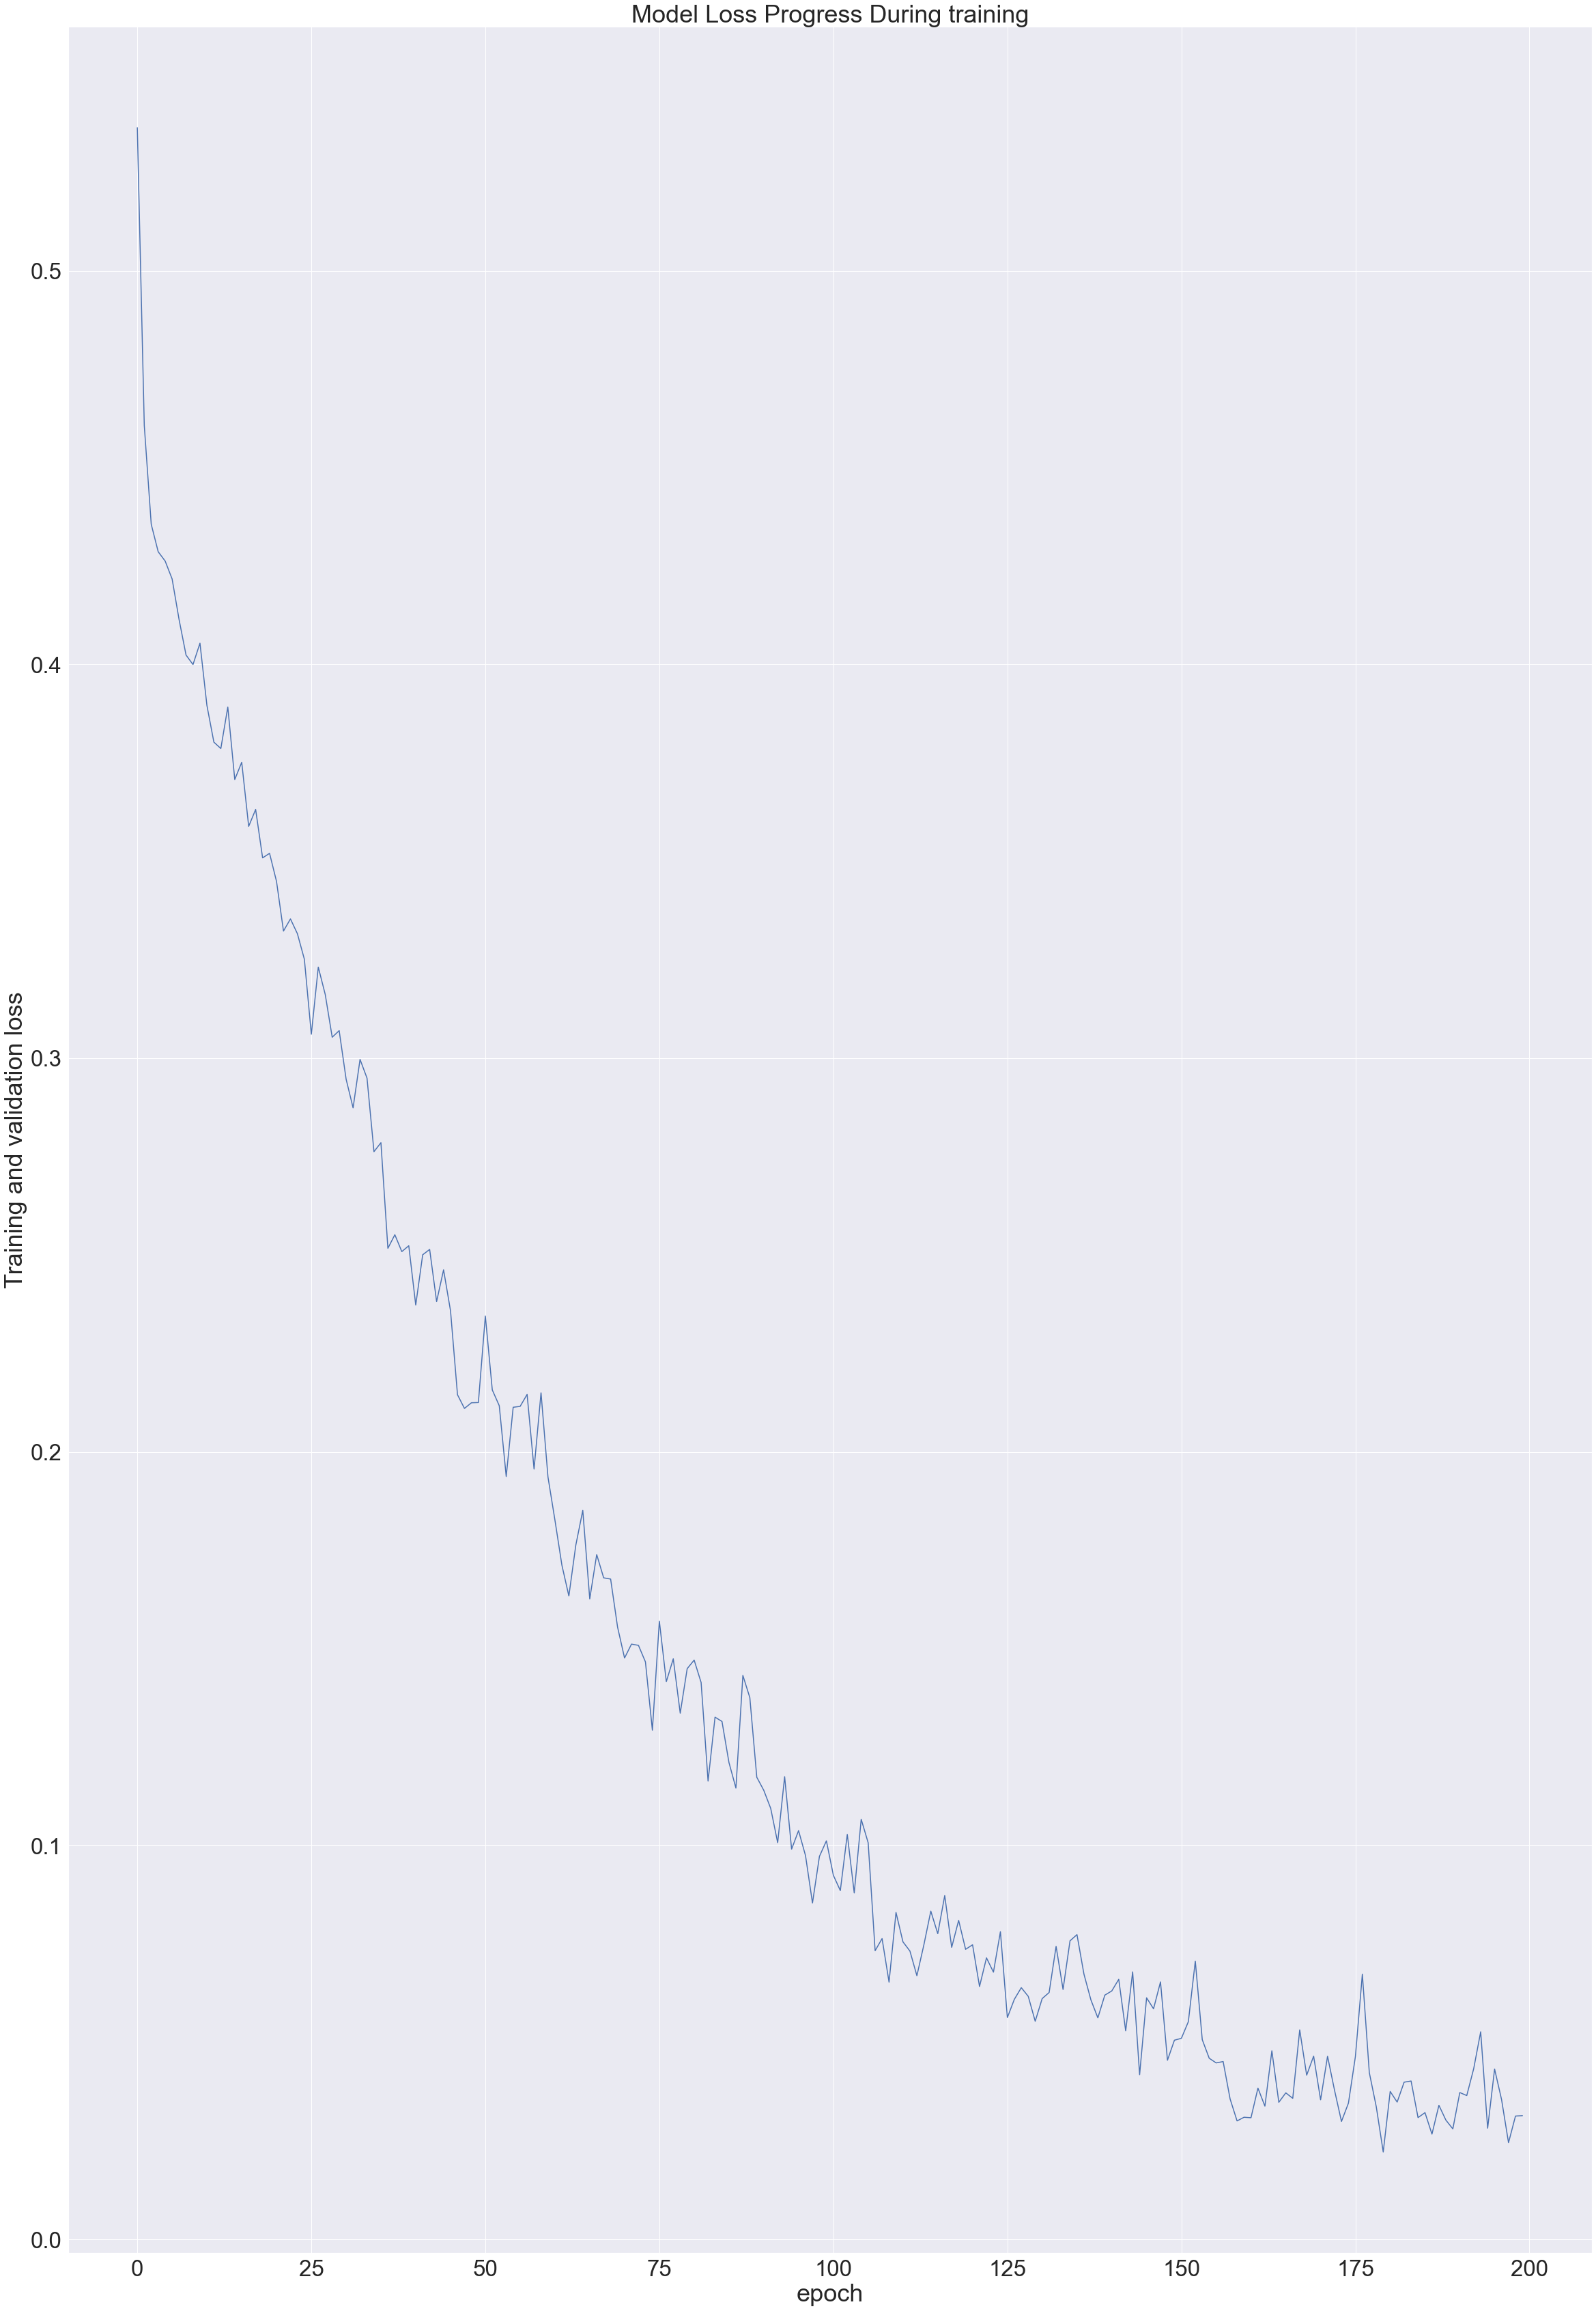

In [203]:
plt.plot(history.history['loss'])
plt.title("Model Loss Progress During training")
plt.xlabel("epoch")
plt.ylabel("Training and validation loss")

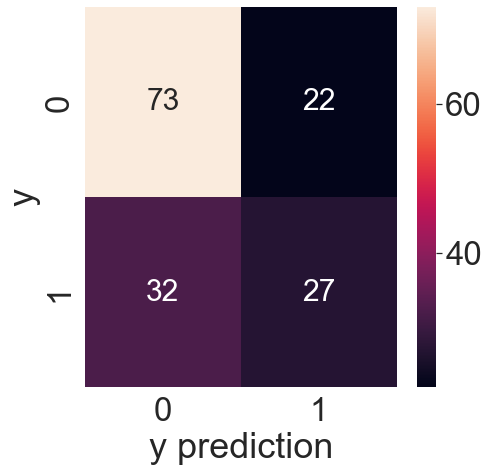

In [204]:
plot_confusion_matrix(y_pred_ANN)

In [176]:
Results_ANN = pd.DataFrame.from_dict({'Model': ['Neural Network'], 'Accuracy': [accuracy_score(y_test, y_pred_ANN)], 'Precision': [precision_score(y_test, y_pred_ANN)], 'Recall': [recall_score(y_test, y_pred_ANN)], 'F1': [f1_score(y_test, y_pred_ANN)], 'AUC': [roc_auc_score(y_test, y_pred_ANN)]})
Results_ANN

,Model,Accuracy,Precision,Recall,F1,AUC
0,Neural Network,0.701299,0.638298,0.508475,0.566038,0.664764


## Conclusion

# Bibliographie :
Dataset :
https://www.kaggle.com/datasets/mathchi/diabetes-data-set?resource=download 